In [5]:
import os
from datetime import datetime 

In [119]:
#set FIXED variables
HOMEPATH = "/home/ubuntu/fastai/"
MODELPATH = HOMEPATH + 'dogscats/models/'
TRAINPATH = HOMEPATH + 'dogscats/train/'
VALIDPATH = HOMEPATH + 'dogscats/valid/'
TESTPATH = HOMEPATH + 'dogscats/test1/'


In [3]:
os.chdir(HOMEPATH)
print (os.getcwd())

/home/ubuntu/fastai


In [4]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline

import utils; reload(utils)
from utils import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


In [6]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [12]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [13]:
# batch_size=100
batch_size=4

In [14]:
os.chdir(HOMEPATH)
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
print (type(model))

<class 'keras.models.Sequential'>


In [121]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(VALIDPATH, shuffle=False, batch_size=1)
batches = get_batches(TRAINPATH, shuffle=False, batch_size=1)


Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [16]:
import bcolz

#NB: filename can to be absolute or relative to current working directory.
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): 
    return bcolz.open(fname)[:]

In [17]:
val_data = get_data(VALIDPATH)

Found 2000 images belonging to 2 classes.
<type 'numpy.ndarray'>


In [20]:
print (type(val_data), val_data.shape)
#2000 images, color and 224x224 pixels. color is RGB so each image is 3 x 224 x 224

<type 'numpy.ndarray'> (2000, 3, 224, 224)


In [22]:
startTime= datetime.now()
trn_data = get_data(TRAINPATH)
print (type(trn_data), trn_data.shape)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

#this takes long time to run? 

Found 23000 images belonging to 2 classes.
<type 'numpy.ndarray'> (23000, 3, 224, 224)


In [23]:
#save this data to file for faster reloading in future.
save_array(MODELPATH+'train_data.bc', trn_data)
save_array(MODELPATH+'valid_data.bc', val_data)

In [24]:
print ("trn_data.shape:", trn_data.shape)
print ("val_data.shape:", val_data.shape)

trn_data.shape: (23000, 3, 224, 224)
val_data.shape: (2000, 3, 224, 224)


In [25]:
#nb: sklearn.preprocessing.OneHotEncoder
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
#
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [29]:
val_classes = val_batches.classes
trn_classes = batches.classes
print ("val_batches:", type(val_batches))
print ("trn_classes:", type(trn_classes))
print ("val_classes:", type(val_classes), val_classes.shape, val_classes[0].shape)
print ("trn_classes:", type(trn_classes), trn_classes.shape, trn_classes[0].shape)

val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
trn_classes: <type 'numpy.ndarray'>
val_classes: <type 'numpy.ndarray'> (2000,) ()
trn_classes: <type 'numpy.ndarray'> (23000,) ()


In [30]:
startTime= datetime.now()
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


Time elpased (hh:mm:ss.ms) 0:00:00.009100


In [32]:
print (type(val_labels), val_labels.shape, val_labels[0])
print (type(trn_labels), trn_labels.shape, trn_labels[0])

<type 'numpy.ndarray'> (2000, 2) [ 1.  0.]
<type 'numpy.ndarray'> (23000, 2) [ 1.  0.]


In [38]:
print (val_classes[:4])
print (trn_classes[:4])
trn_classes[:4]

[0 0 0 0]
[0 0 0 0]


array([0, 0, 0, 0], dtype=int32)

In [34]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [35]:
val_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [37]:
print (val_classes[:4])

[0 0 0 0]


In [48]:
print("start")
startTime= datetime.now() 
trn_features = model.predict(trn_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime 
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))
timeElapsed=datetime.now()-startTime 
val_features = model.predict(val_data, batch_size=batch_size)
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

start
Time elpased (hh:mm:ss.ms) 0:10:31.909249
Time elpased (hh:mm:ss.ms) 0:10:31.909742


In [49]:
print ("trn_features:", type(trn_features), trn_features.shape)
print ("val_features:", type(val_features), val_features.shape)


trn_features: <type 'numpy.ndarray'> (23000, 1000)
val_features: <type 'numpy.ndarray'> (2000, 1000)


In [50]:
save_array(MODELPATH+'train_lastlayer_features.bc', trn_features)
save_array(MODELPATH+'valid_lastlayer_features.bc', val_features)

In [51]:
trn_features = load_array(MODELPATH+'train_lastlayer_features.bc')
val_features = load_array(MODELPATH+'valid_lastlayer_features.bc')

In [52]:

startTime= datetime.now()
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

#keras.models.Sequential
#
startTime= datetime.now()
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

#compile(self, optimizer, loss, metrics=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
#.compile (...) configures the model for training

#this is very quick. 0.01 and 0.02 seconds

Time elpased (hh:mm:ss.ms) 0:00:00.092699
Time elpased (hh:mm:ss.ms) 0:00:00.022654


In [53]:
print (type(lm))
print (type(lm.layers), len(lm.layers))

<class 'keras.models.Sequential'>
<type 'list'> 1


In [54]:
batch_size=4

In [55]:
startTime= datetime.now()
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))
#each epoch takes approx 14 s on AWS p2.xlarge
#total run time approx 44 s  on AWS p2.xlarge

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 14s - loss: 0.5115 - acc: 0.8553 - val_loss: 0.6041 - val_acc: 0.8600
Epoch 2/3
23000/23000 [==============================] - 14s - loss: 0.6644 - acc: 0.8626 - val_loss: 0.7450 - val_acc: 0.8550
Epoch 3/3
23000/23000 [==============================] - 14s - loss: 0.7775 - acc: 0.8614 - val_loss: 0.8623 - val_acc: 0.8655
Time elpased (hh:mm:ss.ms) 0:00:44.130102


In [56]:
type(lm)

keras.models.Sequential

In [58]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 2)             2002        dense_input_4[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [59]:
from datetime import datetime 
startTime= datetime.now() 
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
timeElapsed=datetime.now()-startTime 
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))
timeElapsed=datetime.now()-startTime 
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

1976/2000 [============================>.] - ETA: 0sTime elpased (hh:mm:ss.ms) 0:00:00.512401


In [91]:
def plots_filenames(filenames, titles=None):
    plots([image.load_img(VALIDPATH+ filename) for filename in filenames], titles=titles)

In [92]:
print(type(probs), probs.shape)
print(type(preds), preds.shape)
print (probs[:8])
print (preds[:8])
print (filenames[0:8])

<type 'numpy.ndarray'> (2000,)
<type 'numpy.ndarray'> (2000,)
[ 1.      0.9999  1.      0.9763  0.9985  0.9959  1.      0.0118]
[0 0 0 0 0 0 0 1]
['cats/cat.1935.jpg', 'cats/cat.12009.jpg', 'cats/cat.6320.jpg', 'cats/cat.2203.jpg', 'cats/cat.3808.jpg', 'cats/cat.9121.jpg', 'cats/cat.9895.jpg', 'cats/cat.2283.jpg']


['cats/cat.3808.jpg', 'cats/cat.9121.jpg', 'cats/cat.9895.jpg', 'cats/cat.2283.jpg']
plotted


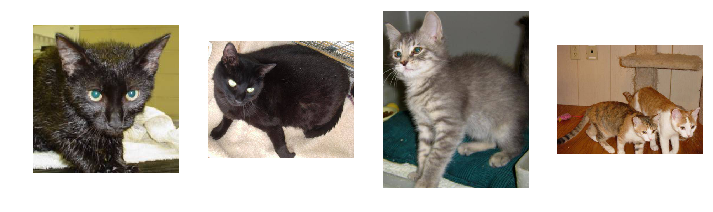

In [94]:
print (filenames[4:8])
plots_filenames(filenames[4:8])
print ("plotted")

In [61]:
filenames = val_batches.filenames
print (type(filenames), len(filenames))

<type 'list'> 2000


In [67]:
filenames[0:10]

['cats/cat.1935.jpg',
 'cats/cat.12009.jpg',
 'cats/cat.6320.jpg',
 'cats/cat.2203.jpg',
 'cats/cat.3808.jpg',
 'cats/cat.9121.jpg',
 'cats/cat.9895.jpg',
 'cats/cat.2283.jpg',
 'cats/cat.6779.jpg',
 'cats/cat.7318.jpg']

In [65]:
cm = confusion_matrix(val_classes, preds)
print (type(cm), cm.shape)
print (cm)

<type 'numpy.ndarray'> (2, 2)
[[832 168]
 [101 899]]


[[832 168]
 [101 899]]


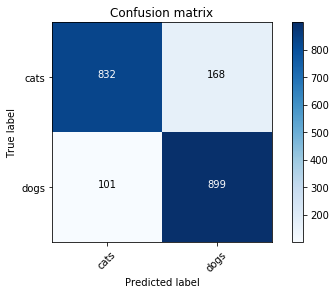

In [64]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [77]:
fileNums = []
for filename in filenames:
    #print (filename)
    start = filename.find('.') 
    end = filename.rfind('.')
    temp = int(filename[start+1:end])
    #print (start, end, temp)
    fileNums.append(temp)
#print (fileNums)

In [96]:
probsDog = [1-prob for prob in probs]
print (probsDog[0:8])

[0.0, 6.580352783203125e-05, 1.5497207641601562e-06, 0.023685991764068604, 0.0015286803245544434, 0.0041186809539794922, 0.0, 0.9881967892870307]


In [99]:
probsDog = np.array(probsDog).clip(0.05, 0.95)
probsDog[0:12]

array([ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.95,  0.05,  0.05,  0.05,  0.05])

In [100]:
filenames[0:12]

['cats/cat.1935.jpg',
 'cats/cat.12009.jpg',
 'cats/cat.6320.jpg',
 'cats/cat.2203.jpg',
 'cats/cat.3808.jpg',
 'cats/cat.9121.jpg',
 'cats/cat.9895.jpg',
 'cats/cat.2283.jpg',
 'cats/cat.6779.jpg',
 'cats/cat.7318.jpg',
 'cats/cat.11958.jpg',
 'cats/cat.3654.jpg']

In [102]:
subm = np.stack([fileNums, probsDog], axis=1)
subm[:5]

array([[  1.9350e+03,   5.0000e-02],
       [  1.2009e+04,   5.0000e-02],
       [  6.3200e+03,   5.0000e-02],
       [  2.2030e+03,   5.0000e-02],
       [  3.8080e+03,   5.0000e-02]])

In [117]:
filename = MODELPATH+'submit.csv'
np.savetxt(filename, subm, fmt='%d,%.5f', header='id,label', comments='')

In [116]:
from IPython.display import HTML
import base64

subm = pd.DataFrame(subm)
print (type(subm))
subm.head()

csv = subm.to_csv()
b64 = base64.b64encode(csv.encode())
payload = b64.decode()

filename2 = MODELPATH+'submit2.csv'

html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
html = html.format(payload=payload,title="Download CSV file",filename=filename)
HTML(html)


<class 'pandas.core.frame.DataFrame'>


,0,1
0,1935.0,0.05
1,12009.0,0.05
2,6320.0,0.05
3,2203.0,0.05
4,3808.0,0.05
